# 2D Linear Elastic Plane-strain Problem

<div class="alert alert-block alert-info">
<b>Note:</b> Problem definition and images are from reference [1]
</div>

See: [Reference](#references)

Problem Description:

An elastic plane-strain problem defined on the unit square.

PDE:

$$
\begin{aligned}
\sigma_{ij,j}+f_i &= 0 \\
\sigma_{ij} &= \lambda \delta_{ij} \epsilon_{kk}+2\mu \epsilon_{ij} \\
\epsilon_{ij} &= \frac{1}{2} \left ( u_{i,j} + u_{j,i} \right )
\end{aligned}
$$

Subjected to the following boundary conditions:

$$
\begin{aligned}
f_x &= \lambda \left [ 4 \pi^2 cos(2\pi x)sin(\pi y) - \pi cos(\pi x) Qy^3 \right ] \\
    &+ \mu \left [ 9\pi^2 cos(2\pi x)sin(\pi y) - \pi cos(\pi x)Qy^3 \right ] \\

f_y &= \lambda \left [ -3 sin(\pi x)Qy^2 + 2\pi^2 sin(2\pi x)cos(\pi y) \right ] \\
    &+ \mu \left [ -6 sin(\pi x)Qy^2 +2 \pi^2 sin(2\pi x)cos(\pi y) + \pi^2 sin(\pi x)Qy^4 / 4\right ]
\end{aligned}
$$

Solution: ($\lambda = 1, \mu = 0.5 \space and \space Q = 4$)

$$
\begin{aligned}
u_x(x,y) &= cos(2\pi x)sin(\pi y) \\
u_y(x,y) &= sin(\pi x)Qy^4/4
\end{aligned}
$$

## 1. Import and setup random seeds

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import pi as pi
from torch import sin as sin
from torch import cos as cos
import matplotlib.pyplot as plt


def set_seeds(seeds):
    torch.manual_seed(seeds)
    torch.cuda.manual_seed(seeds)
    torch.backends.cudnn.deterministic = True

set_seeds(12)

g:\software\Anaconda\envs\yolov5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Define MLP model

![PINN Framework](./assets/img/pinn-for-beam-systems.png)

In [2]:
# input x, y, output u_x and u_y
class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()
        self.model = torch.nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.model(x)

## 3. Define loss function

In [19]:
# mean square loss
mse_loss = nn.MSELoss()


# gradient
def gradient(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, only_inputs=True)[0]
    else:
        return gradient(gradient(u, x), x, order-1)


def loss_u_x0(model, device, sampling_num=4000):
    """
    u(x, 0) = sin(x)
    """

    x = torch.rand(sampling_num, 1, requires_grad=True, device=device) * pi
    t = torch.zeros_like(x, requires_grad=True, device=device)
    u_x0 = model(torch.cat([x, t], dim=1))[:, 0].view(-1, 1)
    cond = sin(x)
    
    return mse_loss(u_x0, cond)


def loss_u_0t(model, device, sampling_num=2000):
    """
    u(0, t) = 0
    """

    t = torch.rand(sampling_num, 1, requires_grad=True, device=device)
    x = torch.zeros_like(t, requires_grad=True, device=device)
    u_0t = model(torch.cat([x, t], dim=1))[:, 0].view(-1, 1)
    cond = torch.zeros_like(t, requires_grad=True, device=device)
    
    return mse_loss(u_0t, cond)


def loss_u_pit(model, device, sampling_num=2000):
    """
    u(pi, t) = 0
    """

    t = torch.rand(sampling_num, 1, requires_grad=True, device=device)
    x = torch.ones_like(t, requires_grad=True, device=device) * pi
    u_pit = model(torch.cat([x, t], dim=1))[:, 0].view(-1, 1)
    cond = torch.zeros_like(t, requires_grad=True, device=device)
    
    return mse_loss(u_pit, cond)


def loss_ut_x0(model, device, sampling_num=4000):
    """
    ut(x, 0) = 0
    """

    x = torch.rand(sampling_num, 1, requires_grad=True, device=device) * pi
    t = torch.zeros_like(x, requires_grad=True, device=device)
    u_x0 = model(torch.cat([x, t], dim=1))[:, 0].view(-1, 1)
    ut_x0 = gradient(u_x0, t, 1)
    cond = torch.zeros_like(x, requires_grad=True, device=device)
    
    return mse_loss(ut_x0, cond)


def loss_uxx_0t(model, device, sampling_num=2000):
    """
    uxx(0, t) = 0
    """

    t = torch.rand(sampling_num, 1, requires_grad=True, device=device)
    x = torch.zeros_like(t, requires_grad=True, device=device)
    u0t = model(torch.cat([x, t], dim=1))[:, 0].view(-1, 1)
    uxx_0t = gradient(u0t, x, 2)
    cond = torch.zeros_like(t, requires_grad=True, device=device)
    
    return mse_loss(uxx_0t, cond)


def loss_uxx_pit(model, device, sampling_num=2000):
    """
    uxx(pi, t) = 0
    """

    t = torch.rand(sampling_num, 1, requires_grad=True, device=device)
    x = torch.ones_like(t, requires_grad=True, device=device) * pi
    upit = model(torch.cat([x, t], dim=1))[:, 0].view(-1, 1)
    uxx_pit = gradient(upit, x, 2)
    cond = torch.zeros_like(t, requires_grad=True, device=device)
    
    return mse_loss(uxx_pit, cond)


def loss_pde(model, device, sampling_num_x=10000, sampling_num_t=10000):
    """
    $$
    u_{tt} + u_{xxxx} = f(x, t) = (1 - 16 \pi^2) sin(\pi x) cos(4 \pi t)
    $$
    """

    x = torch.rand(sampling_num_x, 1, requires_grad=True, device=device)
    t = torch.rand(sampling_num_t, 1, requires_grad=True, device=device)
    u = model(torch.cat([x, t], dim=1))

    u_tt = gradient(u, t, 2)
    u_xxxx = gradient(u, x, 4)

    cond = (1 - 16 * pi**2) * sin(x) * cos(4 * pi * t)
    
    return mse_loss(u_tt + u_xxxx, cond)


# def loss_interior(model, device, sampling_num=10000):
#     """
#     real solution:
#         u(x, t) = sin(x) * cos(4 * pi * t)
#     """

#     x = torch.rand(sampling_num, 1, requires_grad=True).to(device=device) * pi
#     t = torch.rand(sampling_num, 1, requires_grad=True).to(device=device)
#     u = model(torch.cat([x, t], dim=1))
#     cond = sin(x) * cos(4 * pi * t)

#     return mse_loss(u, cond)

## 4. Training

In [ ]:
# set training parameters
num_epochs = 15000
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# record loss
loss_list = []
best_loss = 1.0E10

# training
model = MLP().to(device=device)
optimizer = torch.optim.Adam(params=model.parameters())

for epoch in range(num_epochs):
    def closure():
    
        optimizer.zero_grad()

        l00 = loss_u_x0(model, device)
        l01 = loss_u_0t(model, device)
        l02 = loss_u_pit(model, device)
        l03 = loss_ut_x0(model, device)
        l04 = loss_uxx_0t(model, device)
        l05 = loss_uxx_pit(model, device)
        l06 = 0.001 * loss_pde(model, device)
        # l07 = loss_interior(model, device)

        loss =  l00 + l01 + l02 + l03 + l04 + l05 + l06

        loss.backward()
        return loss
    
    optimizer.step()

    if epoch % 100 == 0:
        # print("Epoch: ", epoch, " loss: ", loss.item())
        print("Epoch: ", epoch, end="\t")
        print("{:.4f}".format(loss.item()), sep='\t')

    # save model
    loss_list.append(loss.item()) # record loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "./assets/beam.pth")


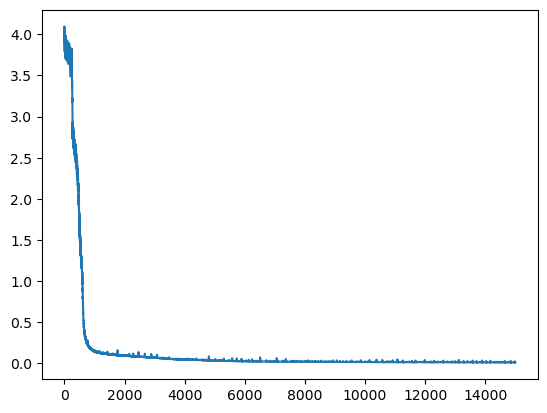

In [8]:
# plot loss
plt.plot(np.array(loss_list))

## 5. Inference and visualization

In [14]:
# mesh
n_mesh = 101 # 画图网格密度

xc = torch.linspace(0, pi, n_mesh)
tc = torch.linspace(0, 1, n_mesh)
xm, tm = torch.meshgrid(xc, tc)

# real
u_real = sin(xm) * cos(4 * pi * tm)

# load model
model = MLP()
model.load_state_dict(torch.load("./assets/beam.pth"))

# prediction & error
xx = xm.reshape(-1, 1)
tt = tm.reshape(-1, 1)
xt = torch.cat([xx, tt], dim=1)

u_pred = model(xt)[:, 0].reshape(xm.shape)
u_error = torch.abs(u_pred - u_real)

# plot
xm = xm.detach().numpy()
tm = tm.detach().numpy()

u_real = u_real.detach().numpy()
u_pred = u_pred.detach().numpy()
u_error = u_error.detach().numpy()

In [17]:
def my_subplot(x, y, *data):
    """
    len(data) == 3
    """

    assert(len(data) == 3)

    fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))
    label_list = ["Pred", "Real", "Error"]

    for i in range(3):
        im = axes[i].pcolormesh(x, y, data[i], cmap=plt.cm.rainbow)
        axes[i].text(0.5, 0.9, label_list[i], transform=axes[i].transAxes)
        fig.colorbar(im, ax=axes[i])

    plt.show()

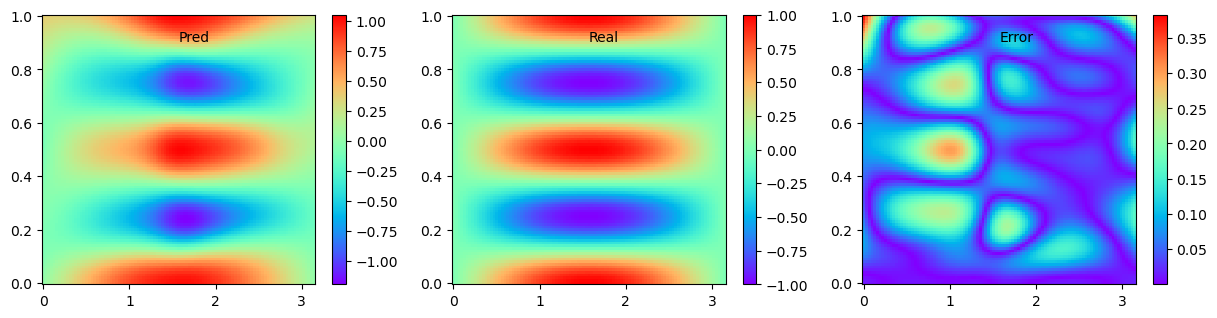

In [18]:
# ux
my_subplot(xm, tm, u_pred, u_real, u_error)

## References

[1] E. Haghighat, M. Raissi, A. Moure, H. Gomez, R. Juanes, A deep learning framework for solution and discovery in solid mechanics, (2020). http://arxiv.org/abs/2003.02751 (accessed June 25, 2023).
